# aQa Final Project: Qualitive comparison of Quantum Neural Networks and Classical Neural Networks

Firstly, import the correct libraries. This may take some time.

In [2]:
import tensorflow as tf

import cirq
import numpy as np
import seaborn as sns
import time

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline
import matplotlib.pyplot as plt

2024-05-24 20:07:35.198523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-24 20:07:35.198566: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Next, we will define the depth and the number of qubits. We can sweep these variables later. <br>
We can also generate the rotations that will generate the random data.

In [43]:
np.random.seed(18)
depth = 3
n_qubits = 3

randomRotations = np.random.uniform(-2*np.pi , 2 * np.pi, (depth * n_qubits))

# Circuits

### Quantum Neural network

We first define the quantum neural network. This is a simple circuit with a few layers of rotations and entanglements. We will use this circuit to classify the data.

In [44]:
def buildQuantumModel(encoding: np.array, parameters: np.array, depth : int, n_qubits : int) -> None:
    qubits = cirq.LineQubit.range(n_qubits)

    #encoding layer
    yield [cirq.ry(encoding[i])(qubits[i]) for i in range(n_qubits)]
    yield [cirq.rx(encoding[i])(qubits[i]) for i in range(n_qubits)]

    #variational layer
    for l in range(depth):
        for i in range(n_qubits):
            yield cirq.rx(parameters[i + l*n_qubits])(qubits[i])
        for i in range(n_qubits-1):
            yield cirq.CZ(qubits[i], qubits[i+1])


    #readout layer
    yield cirq.measure(qubits[0], key='z0')

simulator = cirq.Simulator()

Secondly, we define the `partial quantum model`, which has the same structure as the quantum neural network, but with an extra encoding layer inbetween even layers.

In [45]:
def buildPartialQuantumModel(encoding: np.array, parameters: np.array, depth : int, n_qubits : int) -> None:
    qubits = cirq.LineQubit.range(n_qubits)

    #encoding layer
    yield [cirq.ry(encoding[i])(qubits[i]) for i in range(n_qubits)]
    yield [cirq.rx(encoding[i])(qubits[i]) for i in range(n_qubits)]



    #variational layer
    for l in range(depth):
        for i in range(n_qubits):
            yield cirq.rx(parameters[i + l*n_qubits])(qubits[i])
        for i in range(n_qubits-1):
            yield cirq.CZ(qubits[i], qubits[i+1])

        if l % 2 == 0:
            yield [cirq.ry(encoding[i])(qubits[i]) for i in range(n_qubits)]
            yield [cirq.rx(encoding[i])(qubits[i]) for i in range(n_qubits)]


    #readout layer
    yield cirq.measure(qubits[0], key='z0')

simulator = cirq.Simulator()

Thirdly, we define the `reuploading quantum model`, which has the same structure as the quantum neural network, but with an extra encoding layer inbetween every layer.

In [46]:
def buildReuploadQuantumModel(encoding: np.array, parameters: np.array, depth : int, n_qubits : int) -> None:
    qubits = cirq.LineQubit.range(n_qubits)

    
    #encoding layer
    yield [cirq.ry(encoding[i])(qubits[i]) for i in range(n_qubits)]
    yield [cirq.rx(encoding[i])(qubits[i]) for i in range(n_qubits)]



    #variational layer
    for l in range(depth):
        for i in range(n_qubits):
            yield cirq.rx(parameters[i + l*n_qubits])(qubits[i])
        for i in range(n_qubits-1):
            yield cirq.CZ(qubits[i], qubits[i+1])

        yield [cirq.ry(encoding[i])(qubits[i]) for i in range(n_qubits)]
        yield [cirq.rx(encoding[i])(qubits[i]) for i in range(n_qubits)]


    #readout layer
    yield cirq.measure(qubits[0], key='z0')

simulator = cirq.Simulator()

As the quantum neural network output needs to be simulated, we need to built these for each of the QNN.

In [47]:
def runCircuit(data : np.array, parameters : np.array) -> float:


    quantumModel = cirq.Circuit(buildQuantumModel(data, parameters, depth, n_qubits))
    result = simulator.run(quantumModel, repetitions=100)

    result = np.mean(result.measurements['z0'])

    return result

def runPartialCircuit(data : np.array, parameters : np.array) -> float:

    
    quantumModel = cirq.Circuit(buildPartialQuantumModel(data, parameters, depth, n_qubits))
    result = simulator.run(quantumModel, repetitions=100)
    
    result = np.mean(result.measurements['z0'])
    
    return result

def runReuploadCircuit(data : np.array, parameters : np.array) -> float:

    
    quantumModel = cirq.Circuit(buildReuploadQuantumModel(data, parameters, depth, n_qubits))
    result = simulator.run(quantumModel, repetitions=100)
    
    result = np.mean(result.measurements['z0'])
    
    return result
      


### Classical Neural network

Lastly, we define the classical neural network. This is a simple neural network with a simple leaky relu dense layers and a sigmoid output layer.

In [48]:
def buildClassicalModel(depth : int , trainable : bool) -> tf.keras.Sequential:

    classicModel = tf.keras.Sequential()
    
    for l in range(depth):
        classicModel.add(tf.keras.layers.Dense(n_qubits, activation='leaky_relu', trainable=trainable))

    classicModel.add(tf.keras.layers.Dense(1, activation='sigmoid', trainable=trainable))

    return classicModel

classicModel = buildClassicalModel(depth, True)
dataClassicalModel = buildClassicalModel(depth, False)

## Data generation

### Classic data

In [8]:
def generateClassicSamples(samples : int) -> np.array:

    empty = np.array([])

    for i in range(samples):
        empty = np.append(empty, np.random.uniform(-1, 1, 2))

    empty = empty.reshape(samples, 2)
    

    data = np.zeros((empty.shape[0], empty.shape[1] + 1))
    data[:,:2] = empty
    data[:,-1] = empty[:,0]*empty[:,1]

    return data

In [13]:
dataClassicalModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classicData = generateClassicSamples(1000)


classicLabels = dataClassicalModel.predict(classicData)
onelabel = zerolabel = 0

for i in range(len(classicLabels)):
    if classicLabels[i] > 0.498:
        classicLabels[i] = 1
        onelabel += 1
    else:
        classicLabels[i] = 0
        zerolabel += 1

[[-0.38336646 -0.43111381  0.16527458]
 [-0.92757359 -0.65854242  0.61084655]
 [-0.13925357 -0.84762253  0.11803446]
 ...
 [ 0.67961139  0.17609238  0.11967439]
 [-0.12281973 -0.4415949   0.05423657]
 [-0.45552018 -0.16278546  0.07415206]]
[[0.49863395]
 [0.49772042]
 [0.49619964]
 [0.4992053 ]
 [0.49929872]
 [0.49998146]
 [0.4976012 ]
 [0.4970151 ]
 [0.49879307]
 [0.4990748 ]
 [0.49812374]
 [0.49560148]
 [0.49875984]
 [0.4946121 ]
 [0.49898565]
 [0.49907005]
 [0.49859956]
 [0.49953383]
 [0.49624482]
 [0.49475926]
 [0.49879155]
 [0.49359694]
 [0.49995586]
 [0.49907357]
 [0.4999378 ]
 [0.4993386 ]
 [0.4990271 ]
 [0.49680525]
 [0.49704292]
 [0.49861833]
 [0.49371013]
 [0.49998295]
 [0.49640948]
 [0.4977889 ]
 [0.4999346 ]
 [0.49918726]
 [0.4944333 ]
 [0.49872765]
 [0.4993061 ]
 [0.499137  ]
 [0.49929562]
 [0.49553743]
 [0.495618  ]
 [0.49919274]
 [0.49993378]
 [0.49698648]
 [0.49361938]
 [0.49591702]
 [0.49521944]
 [0.49573228]
 [0.4967953 ]
 [0.49997285]
 [0.49944565]
 [0.49870834]
 [0.

<Axes: title={'center': 'Classic Data'}, xlabel='x1', ylabel='x2'>

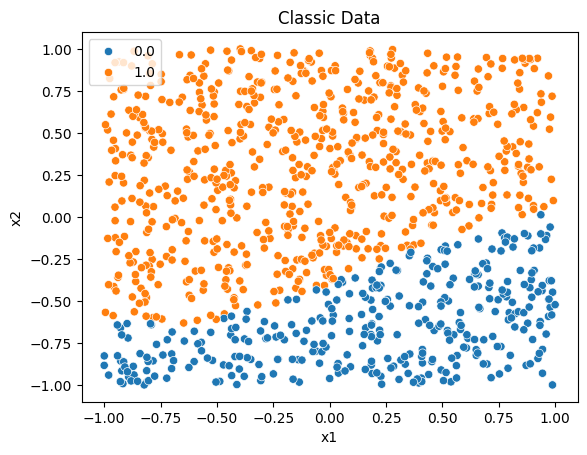

In [14]:
#plot the data points
fig, ax = plt.subplots()
ax.set_title('Classic Data')
ax.set_ylabel('x2')
ax.set_xlabel('x1')
sns.scatterplot(x=classicData[:,0], y=classicData[:,1], hue=classicLabels.flatten(), ax=ax)
fig.savefig('figures/classicData.png')

## Training & Testing

In [36]:
X_train, X_test, y_train, y_test = train_test_split(classicData, classicLabels, test_size=0.33, random_state=4)

classicModel = buildClassicalModel(depth, True)
classicModel.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

y_train = np.array(y_train)
y_test = np.array(y_test)


start = time.time()
classicModel.fit(X_train, y_train, epochs=50)
end = time.time()
print(classicModel.evaluate(X_test, y_test))
print("Time: ", end - start)

Epoch 1/50
21/21 [==============================] - 0s 1ms/step - loss: 0.3275 - accuracy: 0.3284
Epoch 2/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2973 - accuracy: 0.3791
Epoch 3/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2746 - accuracy: 0.4358
Epoch 4/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2587 - accuracy: 0.4851
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.5478
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.6149
Epoch 7/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2376 - accuracy: 0.6597
Epoch 8/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2347 - accuracy: 0.6851
Epoch 9/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2327 - accuracy: 0.6925
Epoch 10/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2307 - accuracy: 0.6970
Epoch 11/50
21/21 [

In [37]:
def calculateLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)
    

cost = []


def optimize(parameters : np.array) -> float:

    singleCost = calculateLoss(parameters, X_train, y_train)
    cost.append(singleCost)

    return singleCost


start = time.time()
result = minimize(optimize, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.13333333333333333
Time 137.96281599998474


In [39]:
def calculatePartialLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runPartialCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizePartial(parameters : np.array) -> float:
    
        singleCost = calculatePartialLoss(parameters, X_train, y_train)
        cost.append(singleCost)
    
        return singleCost


start = time.time()
result = minimize(optimizePartial, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runPartialCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.3939393939393939
Time 180.50407457351685


In [38]:
def calculateReuploadLoss(parameters : np.array, data: np.array, labels: np.array) -> float:


    probs = [runReuploadCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizeReupload(parameters : np.array) -> float:
        
        singleCost = calculateReuploadLoss(parameters, X_train, y_train)
        cost.append(singleCost)
        
        return singleCost



start = time.time()
result = minimize(optimizeReupload, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runReuploadCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.10909090909090909
Time 201.72510933876038


### Quantum data

In [11]:
def generateQuantumSamples(samples : int) -> np.array:

    empty = np.array([])

    for i in range(samples):
        empty = np.append(empty, np.random.uniform(0, 2*np.pi, 2))

    empty = empty.reshape(samples, 2)
    

    data = np.zeros((empty.shape[0], empty.shape[1] + 1))
    data[:,:2] = empty
    data[:,-1] = empty[:,0]*empty[:,1]

    return data

In [12]:
quantumData = generateQuantumSamples(1000)
quantumLabels = [runCircuit(quantumData[i,:], randomRotations) for i in range(len(quantumData))]

onelabel = zerolabel = 0

for i in range(len(quantumLabels)):
    if quantumLabels[i] > 0.5:
        quantumLabels[i] = 1
        onelabel += 1
    else:
        quantumLabels[i] = 0
        zerolabel += 1


[0.56, 0.43, 0.4, 0.51, 0.56, 0.16, 0.36, 0.34, 0.2, 0.35, 0.63, 0.59, 0.54, 0.53, 0.66, 0.6, 0.59, 0.45, 0.48, 0.46, 0.68, 0.35, 0.33, 0.53, 0.3, 0.49, 0.4, 0.31, 0.53, 0.42, 0.66, 0.44, 0.62, 0.62, 0.32, 0.28, 0.64, 0.46, 0.75, 0.52, 0.59, 0.61, 0.59, 0.32, 0.45, 0.41, 0.58, 0.55, 0.5, 0.54, 0.65, 0.33, 0.52, 0.46, 0.57, 0.41, 0.44, 0.44, 0.57, 0.72, 0.72, 0.66, 0.43, 0.66, 0.36, 0.38, 0.3, 0.43, 0.49, 0.52, 0.19, 0.35, 0.41, 0.36, 0.62, 0.51, 0.42, 0.66, 0.52, 0.45, 0.56, 0.28, 0.34, 0.51, 0.66, 0.44, 0.46, 0.35, 0.67, 0.71, 0.33, 0.52, 0.35, 0.41, 0.48, 0.6, 0.53, 0.51, 0.59, 0.28, 0.54, 0.38, 0.38, 0.84, 0.41, 0.28, 0.57, 0.39, 0.57, 0.5, 0.51, 0.32, 0.31, 0.44, 0.38, 0.4, 0.58, 0.29, 0.32, 0.44, 0.43, 0.42, 0.52, 0.71, 0.73, 0.38, 0.28, 0.52, 0.5, 0.6, 0.55, 0.26, 0.62, 0.34, 0.45, 0.18, 0.35, 0.61, 0.37, 0.5, 0.14, 0.31, 0.56, 0.37, 0.38, 0.39, 0.31, 0.27, 0.79, 0.58, 0.48, 0.38, 0.3, 0.52, 0.59, 0.49, 0.44, 0.39, 0.4, 0.49, 0.59, 0.73, 0.38, 0.65, 0.21, 0.3, 0.56, 0.55, 0.55, 0

<Axes: title={'center': 'Basic Quantum Neural Network Generated Data'}, xlabel='x1', ylabel='x2'>

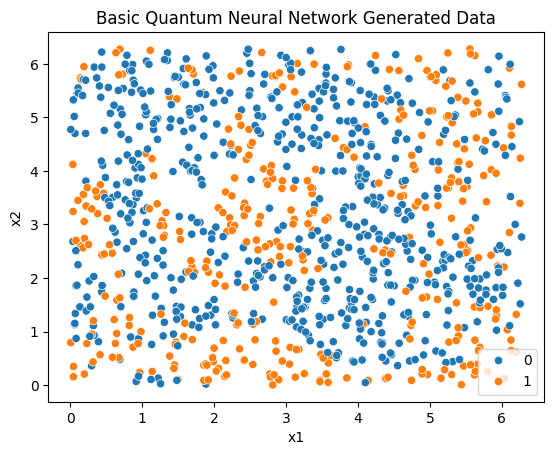

In [13]:
fig, ax = plt.subplots()
ax.set_title('Basic Quantum Neural Network Generated Data')
ax.set_ylabel('x2')
ax.set_xlabel('x1')
sns.scatterplot(x=quantumData[:,0], y=quantumData[:,1], hue=quantumLabels, ax=ax)
fig.savefig('figures/quantumData.png')

In [14]:
partialQuantumData = generateQuantumSamples(1000)
partialQuantumLabels = [runPartialCircuit(quantumData[i,:], randomRotations) for i in range(len(quantumData))]

onelabel = zerolabel = 0

for i in range(len(partialQuantumLabels)):
    if partialQuantumLabels[i] > 0.5:
        partialQuantumLabels[i] = 1
        onelabel += 1
    else:
        partialQuantumLabels[i] = 0
        zerolabel += 1


1s:  531
0s:  469


<Axes: title={'center': 'Partial Quantum Neural Network Generated Data'}, xlabel='x1', ylabel='x2'>

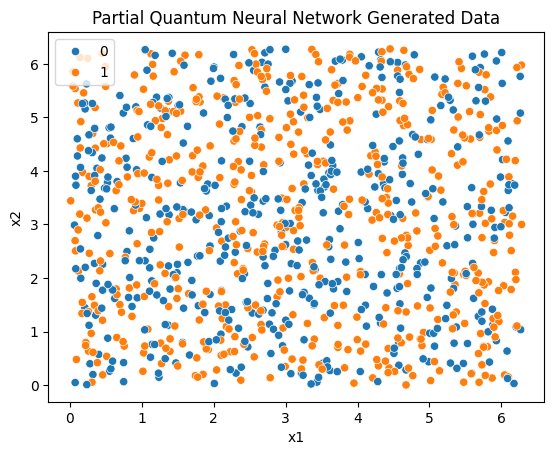

In [15]:
fig, ax = plt.subplots()
ax.set_title('Partial Quantum Neural Network Generated Data')
ax.set_ylabel('x2')
ax.set_xlabel('x1')
sns.scatterplot(x=partialQuantumData[:,0], y=partialQuantumData[:,1], hue=partialQuantumLabels, ax=ax)
fig.savefig('figures/partialQuantumData.png')

In [16]:
reuploadQuantumData = generateQuantumSamples(1000)
reuploadQuantumLabels = [runReuploadCircuit(quantumData[i,:], randomRotations) for i in range(len(quantumData))]

onelabel = zerolabel = 0

for i in range(len(reuploadQuantumLabels)):
    if reuploadQuantumLabels[i] > 0.5:
        reuploadQuantumLabels[i] = 1
        onelabel += 1
    else:
        reuploadQuantumLabels[i] = 0
        zerolabel += 1


1s:  504
0s:  496


<Axes: title={'center': 'Reuploading Quantum Neural Network Generated Data'}, xlabel='x1', ylabel='x2'>

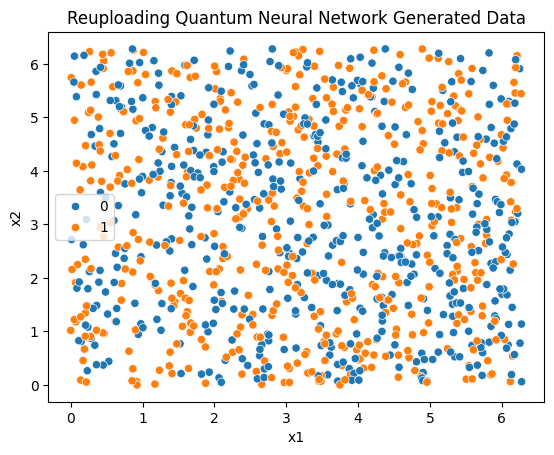

In [17]:
fig, ax = plt.subplots()
ax.set_title('Reuploading Quantum Neural Network Generated Data')
ax.set_ylabel('x2')
ax.set_xlabel('x1')
sns.scatterplot(x=reuploadQuantumData[:,0], y=reuploadQuantumData[:,1], hue=reuploadQuantumLabels, ax=ax)
fig.savefig('figures/reuploadQuantumData.png')

## Training & Testing

In [49]:
X_train, X_test, y_train, y_test = train_test_split(quantumData, quantumLabels, test_size=0.33, random_state=4)

classicModel = buildClassicalModel(depth, True)
classicModel.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

y_train = np.array(y_train)
y_test = np.array(y_test)


start = time.time()
classicModel.fit(X_train, y_train, epochs=50)
end = time.time()
print(classicModel.evaluate(X_test, y_test))
print("Time: ", end - start)

Epoch 1/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3000 - accuracy: 0.4821
Epoch 2/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2480 - accuracy: 0.5507
Epoch 3/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2431 - accuracy: 0.5522
Epoch 4/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2401 - accuracy: 0.5522
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2373 - accuracy: 0.5582
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2352 - accuracy: 0.5836
Epoch 7/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2338 - accuracy: 0.6030
Epoch 8/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2334 - accuracy: 0.6269
Epoch 9/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 0.6239
Epoch 10/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2306 - accuracy: 0.6239
Epoch 11/50
21/21 [

In [50]:
def calculateLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    loss = 0

    probs = [runCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)
    

cost = []


def optimize(parameters : np.array) -> float:

    singleCost = calculateLoss(parameters, X_train, y_train)
    cost.append(singleCost)

    return singleCost


start = time.time()
result = minimize(optimize, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.2818181818181818
Time 135.55217909812927


In [51]:
def calculatePartialLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runPartialCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizePartial(parameters : np.array) -> float:
    
        singleCost = calculatePartialLoss(parameters, X_train, y_train)
        cost.append(singleCost)
    
        return singleCost


start = time.time()
result = minimize(optimizePartial, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runPartialCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.4575757575757576
Time 184.95301055908203


In [52]:
def calculateReuploadLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runReuploadCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizeReupload(parameters : np.array) -> float:
        
        singleCost = calculateReuploadLoss(parameters, X_train, y_train)
        cost.append(singleCost)
        
        return singleCost



start = time.time()
result = minimize(optimizeReupload, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runReuploadCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.48484848484848486
Time 222.85659885406494


In [53]:
X_train, X_test, y_train, y_test = train_test_split(partialQuantumData, partialQuantumLabels, test_size=0.33, random_state=4)

classicModel = buildClassicalModel(depth, True)
classicModel.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

y_train = np.array(y_train)
y_test = np.array(y_test)


start = time.time()
classicModel.fit(X_train, y_train, epochs=50)
end = time.time()
print(classicModel.evaluate(X_test, y_test))
print("Time: ", end - start)

Epoch 1/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.5194
Epoch 2/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2520 - accuracy: 0.5209
Epoch 3/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2492 - accuracy: 0.5119
Epoch 4/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2488 - accuracy: 0.5164
Epoch 5/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2489 - accuracy: 0.5224
Epoch 6/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2490 - accuracy: 0.5343
Epoch 7/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2487 - accuracy: 0.5433
Epoch 8/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2487 - accuracy: 0.5403
Epoch 9/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2488 - accuracy: 0.5284
Epoch 10/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2487 - accuracy: 0.5284
Epoch 11/50
21/21 [

Epoch 19/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2486 - accuracy: 0.5343
Epoch 20/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2490 - accuracy: 0.5433
Epoch 21/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2489 - accuracy: 0.5388
Epoch 22/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2486 - accuracy: 0.5373
Epoch 23/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.5358
Epoch 24/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2486 - accuracy: 0.5448
Epoch 25/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.5448
Epoch 26/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.5448
Epoch 27/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.5418
Epoch 28/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.5448
Epoch 29/5

In [54]:
def calculateLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)
    

cost = []


def optimize(parameters : np.array) -> float:

    singleCost = calculateLoss(parameters, X_train, y_train)
    cost.append(singleCost)

    return singleCost


start = time.time()
result = minimize(optimize, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.5
Time 141.31194615364075


In [55]:
def calculatePartialLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runPartialCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizePartial(parameters : np.array) -> float:
    
        singleCost = calculatePartialLoss(parameters, X_train, y_train)
        cost.append(singleCost)
    
        return singleCost


start = time.time()
result = minimize(optimizePartial, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runPartialCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.5454545454545454
Time 189.7119870185852


In [56]:
def calculateReuploadLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runReuploadCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizeReupload(parameters : np.array) -> float:
        
        singleCost = calculateReuploadLoss(parameters, X_train, y_train)
        cost.append(singleCost)
        
        return singleCost



start = time.time()
result = minimize(optimizeReupload, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runReuploadCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.4666666666666667
Time 203.76211524009705


In [57]:
X_train, X_test, y_train, y_test = train_test_split(reuploadQuantumData, reuploadQuantumLabels, test_size=0.33, random_state=4)

classicModel = buildClassicalModel(depth, True)
classicModel.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

y_train = np.array(y_train)
y_test = np.array(y_test)


start = time.time()
classicModel.fit(X_train, y_train, epochs=50)
end = time.time()
print(classicModel.evaluate(X_test, y_test))
print("Time: ", end - start)

Epoch 1/50
21/21 [==============================] - 0s 1ms/step - loss: 0.3345 - accuracy: 0.4896
Epoch 2/50
 1/21 [>.............................] - ETA: 0s - loss: 0.3052 - accuracy: 0.5625

21/21 [==============================] - 0s 1ms/step - loss: 0.2964 - accuracy: 0.4761
Epoch 3/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2615 - accuracy: 0.4985
Epoch 4/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2498 - accuracy: 0.5343
Epoch 5/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2494 - accuracy: 0.5254
Epoch 6/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2492 - accuracy: 0.5328
Epoch 7/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2493 - accuracy: 0.5343
Epoch 8/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2489 - accuracy: 0.5328
Epoch 9/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2485 - accuracy: 0.5328
Epoch 10/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2489 - accuracy: 0.5358
Epoch 11/50
21/21 [==============================] - 0s 1ms/step - loss: 0.2487 - accuracy: 0.5299
Epoch 12/50
21/21 [==========

In [58]:
def calculateLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    probs = [runCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)
    

cost = []


def optimize(parameters : np.array) -> float:

    singleCost = calculateLoss(parameters, X_train, y_train)
    cost.append(singleCost)

    return singleCost


start = time.time()
result = minimize(optimize, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.5121212121212121
Time 130.66598558425903


In [59]:
def calculatePartialLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    loss = 0

    probs = [runPartialCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizePartial(parameters : np.array) -> float:
    
        singleCost = calculatePartialLoss(parameters, X_train, y_train)
        cost.append(singleCost)
    
        return singleCost


start = time.time()
result = minimize(optimizePartial, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runPartialCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.5121212121212121
Time 179.64383554458618


In [60]:
def calculateReuploadLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    loss = 0

    probs = [runReuploadCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)


cost = []


def optimizeReupload(parameters : np.array) -> float:
        
        singleCost = calculateReuploadLoss(parameters, X_train, y_train)
        cost.append(singleCost)
        
        return singleCost



start = time.time()
result = minimize(optimizeReupload, randomRotations, method='COBYLA', options={"maxiter": 50})
predictedLabels = [runReuploadCircuit(X_test[i,:], result.x) for i in range(len(X_test))]
predictedLabels = [1 if predictedLabels[i] > 0.5 else 0 for i in range(len(predictedLabels))]
end = time.time()
print("MSE: ", str(mse(y_test, predictedLabels)))
print("Time", end - start)

MSE:  0.4909090909090909
Time 217.40706253051758
